# Fluctuation Electron Microscopy Data Analysis Example


## 0.0 Introduction
This notebook shows you how to perform a fluctuation electron mircoscopy (FEM) analysis for a Zr-Cu-Al Sample.  Most of this analysis is done in [pyXEM](https://github.com/pyxem/pyxem) version 13.3. As a package in development there may be some breaking changes with each sucessive itereation.  pyxXEM is an extension of [hyperspy](https://hyperspy.org/hyperspy-doc/current/index.html), so reading some of their documentation is a good place to start in many cases. 

In this notebook we will focus on calculating $V_\Omega (k)$ which is defined as,

Equation 1:   $V_\Omega (k) = \frac{\langle I{^2}(k) \rangle{_r} - \langle I(k)\rangle_r^2}{\langle I(k)\rangle_r^2 } - \frac{G}{\langle I(k)\rangle_r}$,

where $I(k)$ is the diffracted electron intensity averaged over the polar angle at constant scattering vector magnitude $k$, $\langle \rangle_r$ indicates averaging over probe positions $r$, and $G$ is the gain of the electron camera in digital counts / beam electron. The first term is the definition of the variance, and the second term is a correction to the variance for Poisson noise in the data.

(There are several different possible variance signals. Here, we use the notation from Daulton, <i>et al.</i> Ultramicroscopy <b>110</b>, 1279–1289 (2010), DOI: [10.1016/j.ultramic.2010.05.010](https://doi.org/10.1016/j.ultramic.2010.05.010).)

In [1]:
# Warnings on imports are fine Errors are problems
import numpy as np
import hyperspy.api as hs
import glob
import pyxem
from skimage.measure import EllipseModel
from hyperspy.signal import BaseSignal
import matplotlib.pyplot as plt
import hyperspy

/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
# Checking the package versions... 
try:
    assert(float(hyperspy.__version__[0:3])==1.6)
except(AssertionError):
    print("Hyperspy must be version 1.6 or higher for this  notebook to work.  Please refer to the installation"
         "instructions for how to install or reinstall hyperspy")
    
try:
    assert(float(pyxem.__version__[0:4])==0.13)
except(AssertionError):
    print("Pyxem must be version 0.13 or higher for this  notebook to work.  Please refer to the installation"
         "instructions for how to install or reinstall pyxem")
    

## 1.0 Loading and Visualizing the Data 

The example data is a 10x10 STEM dataset with large spacing betweent the probe positions. A HAADF image is also included to use as a reference for the thickness filtering.

The data is currently in the `.hspy` format which is hyperspy's open hdf5 file format.  Hyperspy can load many different file types, a complete list of which is given [here](https://hyperspy.org/hyperspy-doc/current/user_guide/io.html#supported-formats)

In [3]:
signals = glob.glob('fem_data/*')

In [4]:
signals

['fem_data/pos6-2.hdf5',
 'fem_data/pos5-2.hdf5',
 'fem_data/pos5-1.hdf5',
 'fem_data/pos1-2.hdf5',
 'fem_data/pos3-1.hdf5',
 'fem_data/pos4-1.hdf5',
 'fem_data/pos1-1.hdf5',
 'fem_data/pos6-1.hdf5',
 'fem_data/pos3-2.hdf5',
 'fem_data/pos4-2.hdf5']

In [5]:
signal = hs.load(signals[1], signal_type="electron_diffraction")

In [6]:
signal

<ElectronDiffraction2D, title: , dimensions: (10, 10|512, 512)>

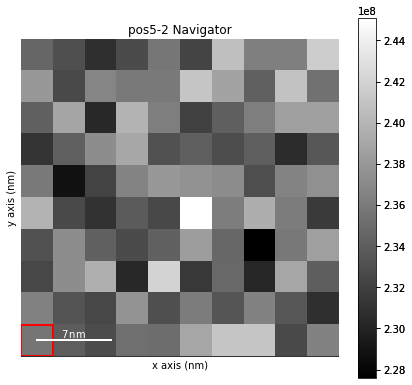

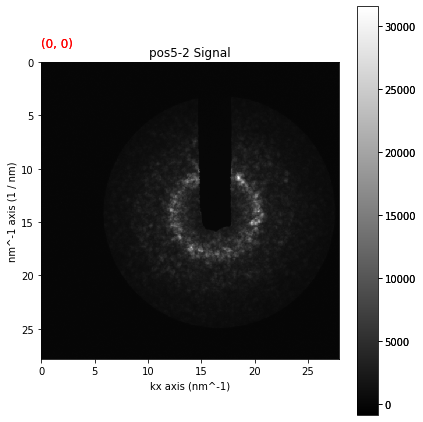

In [7]:
# change the plotting backend to "notebook" to make it intereactive
%matplotlib inline
signal.plot()

## 2.0 Computing the Annular Average of Every Diffraction Pattern

The first step in computing $V_\Omega(k)$ is computing the annular average of each diffraction pattern, converting in effect from a 2D pattern $I(k_x, k_y)$ to a 1D pattern $I(k)$. This step involves finding the center of the pattern, correcting for any ellipticity, then calculating the average.

The following methods below are useful for determing the center of a diffraction pattern if there is a beam stop included in the data.  The intent is to include these methods into pyxem (see https://github.com/pyxem/pyxem/pull/769) but they currently are not included.  If the data don't have a beam stop the [`diffraction_signal.center_direct_beam()`](https://github.com/pyxem/pyxem/blob/de140bb5dc19c0e9d1a91a725c656c2bd2c056d0/pyxem/signals/diffraction2d.py#L698) methods are better.

The method below also provides some ability to correct for ellipticty in the diffraction pattern. In general the best way to see if there is any ellipticity in a diffraction pattern is to visualize at the polar unwrapped diffraction pattern, which is done below. 

In [8]:
def get_max_positions(signal,
                      mask=None,
                      num_points=5000,
                      ):
    """ Gets the top num_points pixels in the dataset.

    Parameters
    --------------
    signal: BaseSignal
        The signal which we want to find the max positions for.
    mask: np.array
        A mask to be applied to the data for values to ignore
    num_points: int
        The number of points to be
    """
    if isinstance(signal, BaseSignal):
        data = signal.data
    else:
        data = signal
    i_shape = np.shape(data)
    flattened_array = data.flatten()
    if mask is not None:
        flattened_mask = mask.flatten()
        flattened_array[flattened_mask]=0
    # take top 5000 points make sure exclude zero beam
    indexes = np.argsort(flattened_array)
    cords = np.array([np.floor_divide(indexes[-num_points:], i_shape[1]),
             np.remainder(indexes[-num_points:], i_shape[1])]) # [x axis (row),y axis (col)]
    return cords.T

def determine_ellipse(signal,
                      mask=None,
                      num_points=1000,
                      **kwargs,
                      ):
    """
    This method starts by taking some number of points which are the most intense
    in the signal.  It then takes those points and guesses some starting parameters
    for the `get_ellipse_model_ransac_single_frame` function. From there it will try
    to determine the ellipse parameters.

    Parameters
    -----------
    signal: Signal2D
        The signal of interest
    mask: Array-like
        The mask to be applied to the data.  All of the masked values are ignored
    num_points: int
        The number of points to consider
    guess_starting_params: bool
        If True then the starting parameters will be guessed based on the points determined.
    **kwargs:
        Any other keywords for ` get_ellipse_model_ransac_single_frame`

    Returns
    -------
    center: (x,y)
        The center of the diffraction pattern
    affine:
        The affine transformation to make the diffraction pattern circular.
    """
    pos = get_max_positions(signal,
                            mask=mask,
                            num_points=num_points)
    e = EllipseModel()
    converge = e.estimate(data=pos)
    el = e
    if el is not None:
        affine = ellipse_to_affine(el.params[3],el.params[2], el.params[4])
        center = (el.params[0],el.params[1])
        return center, affine
    else:
        print("Ransac Ellipse detection did not converge")
        return None

def ellipse_to_affine(major, minor, rot):
    if major < minor:
        print("major<minor")
        temp = major
        major = minor
        minor = temp
        rot=rot+(np.pi/2)

    Q = [[np.cos(rot), -np.sin(rot), 0],
         [np.sin(rot), np.cos(rot), 0],
         [0, 0, 1]]
    S = [[1, 0, 0],
         [0, major / minor, 0],
         [0, 0, 1]]
    C = np.matmul(np.matmul(Q, S), np.transpose(Q))
    return C

In [9]:
center, affine =determine_ellipse(signal.sum())
plt.show()

In [10]:
signal.beam_energy=200
signal.unit="k_nm^-1"
signal.set_ai(center= center)

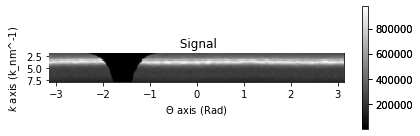

In [11]:
az = signal.get_azimuthal_integral2d(npt=100).sum().isig[:,2.:8.]
az.axes_manager[0].units="Rad"
az.axes_manager[0].name="$\Theta$"
az.axes_manager[1].name="$k$"

az.plot()

## 3.0 Calculating the Variance for Constant Thickness Samples

If the TEM sample is known to have constant thickness, computing the variance from this point is quite easy.  The `get_variance` method can easily calculate the variance using the Azimuthal_Integrator set above with the `set_ai` method. 

Despite its name, the DQE parameter isn't the detector quantum efficiency.  It is the gain of the detector, whcih converts digital counts on the detector into fast electrons.  The number of electrons is then used for the Possion noise correction. If the data are already calibrated in units of electron counts, use a gain of 1.

In [12]:
help(signal.get_variance)

Help on method get_variance in module pyxem.signals.diffraction2d:

get_variance(npt, method='Omega', dqe=None, spatial=False, navigation_axes=None, **kwargs) method of pyxem.signals.electron_diffraction2d.ElectronDiffraction2D instance
    Calculates the variance using one of the methods described in [1]. A shot noise correction and
       and specification of axes to operate over are also possible.
    
    Parameters
    ----------
    npt : int
        The number of points to use in the azimuthal integration
    method : 'Omega' or 'r' or 're' or 'VImage', optional
        The method used to calculate the variance. Details in [1]
    dqe : int, optional
        The detector quantum efficiency or the pixel value for one electron.
    spatial : bool, optional
        Included intermediate spatial variance in output (only avaliable if method=='r')
    navigation_axes : list or none, optional
        The axes to calculate the variance over.  The default is to use the navigation axes.
 

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


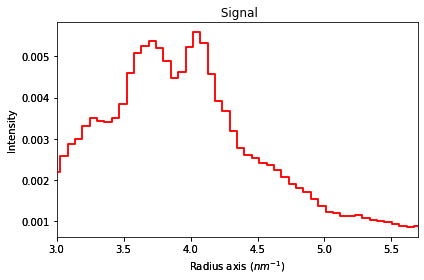

In [13]:
# Note that the y-axis is the varaiance here. Hyperspy just always labels this as "Intensity"
variance  = signal.get_variance(npt=50,dqe=4.2, radial_range=(3.0,5.75))
variance.axes_manager[0].units = "$nm^{-1}$"
variance.plot()

## 4.0 Calculating the Variance for Sample with Varying Thickness

If the TEM sample varies in thickness by more than a few nm over the entire dataset, thickness-related differences in the diffracted intensity $I(k)$ will dominate structure-related differences and therefore dominate $V_\Omega(k)$. This effect can be avoided by using the HAADF signal or the high-angle scattering within the diffraction pattern to determine the local sample thickness, grouping the diffraction patterns into bins of nearly constant thickness, and only computing $V_\Omega(k)$ for data inside a single bin. The $V_\Omega(k)$ from different thickness bins then can be averaged together. See Hwang and Voyles Microscopy and Microanalysis <b>17</b>, 67–74 (2011), DOI: [10.1017/S1431927610094109](https://doi.org/10.1017/S1431927610094109) and Li <i>et al.</i> Microscopy and Microanalysis <b>20</b>, 1605–1618 (2014). DOI: [10.1017/s1431927614012756](https://doi.org/10.1017/s1431927614012756) for more details.

Thickness filtering is not currently built into `pyxem` but preforming some thickness filtering isn't terrribly difficult using the framework available. 

In [14]:
# We have already saved the simultaneously-acquired HAADF image along side the dataset. We can see this here...
signal.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Camera
│       │       └── exposure = 0.000003
│       ├── Stage
│       │   ├── tilt_alpha = 0.0
│       │   ├── tilt_beta = 0.0
│       │   ├── x = 0.5984470000000001
│       │   ├── y = -0.24668500000000002
│       │   └── z = 0.133236
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200
│       ├── camera_length = 510.0
│       ├── magnification = 1300000.0
│       ├── microscope = Titan 300 kV D2080 SuperTwin
│       ├── probe_area = 3.141592653589793
│       ├── probe_resolution = 2.0
│       └── probe_step = 3.0
├── General
│   ├── authors = SUPERVISOR
│   ├── date = 2018-03-28
│   ├── original_filename = pos5-2_1.ser
│   ├── time = 14:46:49
│   └── title = 
├── HAADF
│   ├── filter_intercept = -35.0
│   ├── filter_slope = 0.00221729
│   └── intensity = array([[33619., 34015., 33971., 33800., 33996., 34191., 34041., 33959.,
       ... 68., 34132., 34007., 34117., 33956., 34069., 34274.,
        33771., 33817.]])
├── Sample
│   └── deposition_rate = 0.24
├── Signal
│   ├── Ellipticity
│   │   └── calibrated = False
│   ├── ai = Detector Detector	 Spline= None	 PixelSize= 1.367e-04, 1.367e-04 m
Wavelength= ... m	Center: x=300.101, y=261.124 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
│   ├── binned = False
│   ├── signal_type = electron_diffraction
│   └── type = diffraction_signal
├── convergence_angle = 0.74
└── original_filename = pos5-2.

In [15]:
haadf = hs.signals.Signal2D(signal.metadata.HAADF.intensity)

The HAADF signal for an amorphous material is linear in the thickness for typical TEM sample thicknesses. To convert the HAADF digital counts to thickness (in <i>e.g.</i> nm), the slope and intercept of the linear relationship must be known. The intercept is the black level of the HAADF detector in digital counts, which in this case is 26,265. The slope must be calibrated for each experiment from a measurement of the HAADF intensity at a position of known sample thickness. In this case, the slope is 440.46 digital counts / nm of sample thickness.

TEM sample thickness for amorphous materials can be measured indepedently either using electron energy loss spectroscopy (EELS), in which the inelastic mean free path of the material must be known, or using total elastic scattering, in which case the elastic mean free path of the material must be known. A reasonable model for the elastic mean free path for many inorganic materials may be found in Zhang <i>et al.</i> Ultramicroscopy <b>171</b>, 89–95 (2016), DOI: [10.1016/j.ultramic.2016.09.005](https://doi.org/10.1016/j.ultramic.2016.09.005).

In [16]:
thickness = ((haadf -26265)/440.46)

In [17]:
def thickness_filter(signal, thickness, bins):
    masks = [np.logical_and(bins[i]<thickness, bins[i+1]>thickness) for i in range(len(bins)-1)]
    filtered = [hs.signals.Signal2D(signal.data[m.data,:,:]) for m in masks]
    for f in filtered:
        f.set_signal_type("electron_diffraction")
        f.axes_manager.signal_axes= signal.axes_manager.signal_axes
        f.metadata = signal.metadata
    return filtered, thickness

In [18]:
bins = np.linspace(np.min(thickness, axis=(0,1)), np.max(thickness, axis=(0,1)), num=2+1)
filtered, thickness = thickness_filter(signal, thickness, bins)

In [19]:
var = [f.get_variance(npt=50, dqe=4.2, radial_range=(3.0, 5.7)) for f in filtered]

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


<AxesSubplot:xlabel='Radius ($nm^{-1}$)', ylabel='Intensity'>

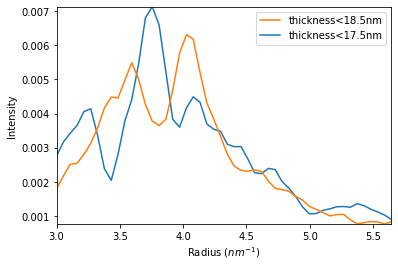

In [20]:
# Note that the y-axis is the varaiance here. Hyperspy just always labels this as "Intensity"
for v in var:
    v.axes_manager[0].units = "$nm^{-1}$"
hs.plot.plot_spectra(var, legend=["thickness<17.5nm","thickness<18.5nm"])

## Further Example 
## (WARNING! This might not work in Binder because of Memory Constraints)

The small example data set analyzed above doesn't contain enough data for a statistically rigorous estimate of the variance. 100 diffraction patterns split into different thicknesses just isn't enough data!

Below we have loaded 10 seperate positions each with a 10x10 dataset collected.  This gets closer to being enough data for a good estimate of $V_\Omega(k)$ with thickness filtering. 

In [21]:
signals = glob.glob('fem_data/*')
signals = hs.load(signals, signal_type="electron_diffraction")

In [22]:
for s in signals:
    center, affine =determine_ellipse(s.sum())
    s.beam_energy=200
    s.unit="k_nm^-1"
    s.set_ai(center= center)
    haadf = hs.signals.Signal2D(s.metadata.HAADF.intensity)

major<minor
major<minor
major<minor
major<minor


In [23]:
var = [s.get_variance(npt=50, dqe=4.2, radial_range=(3.0, 5.7) )for s in signals]

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s


/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=

[(3.0, 5.7), Text(0, 0.5, 'Variance'), Text(0.5, 0, 'k, nm $^{-1}$')]

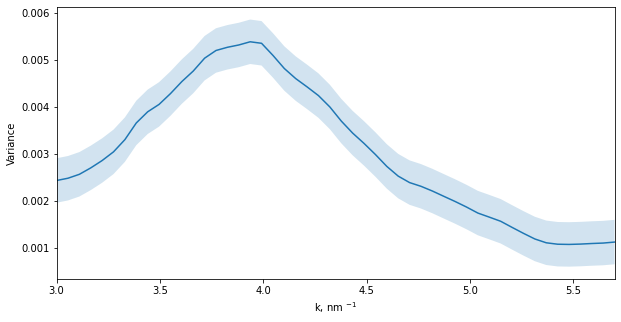

In [24]:
fig, axs =plt.subplots(1,1,figsize=(10,5))

error = np.std([v.data for v in var])/np.sqrt(10)
mean_val = np.mean(var).data
axs.plot(np.linspace(3.0,5.7,50), mean_val)
axs.fill_between(np.linspace(3.0,5.7,50),mean_val-error, mean_val+error, alpha=.2)
axs.set(xlim=(3.0,5.7), ylabel="Variance", xlabel="k, nm $^{-1}$")


## Different Methods for Calculating Variance


Additional methods for calculating varaince are also available as described in Daulton <i>et al.</i> Ultramicroscopy <b>110</b>, 1279–1289, https://doi.org/10.1016/j.ultramic.2010.05.010 Nanobeam diffraction fluctuation electron microscopy technique for structural characterization of disordered materials-Application to Al<sub>88-x</sub>Y<sub>7</sub>Fe<sub>5</sub>Ti<sub>x</sub> metallic glasses. All of the different variance signals are straightforward to calculate using `hyperspy` and `pyxem`.

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100

/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=

[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.1s

/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=

[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/carter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=

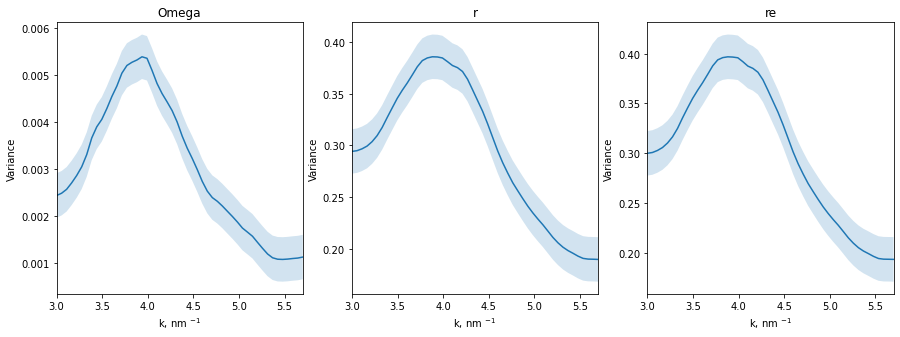

In [25]:
fig, axs =plt.subplots(1,3,figsize=(15,5))
gain=4.2
for method,ax in zip(["Omega", "r", "re"],axs):
    var = [s.get_variance(npt=50, dqe=gain, radial_range=(3.0, 5.7), method=method)for s in signals]
    error = np.std([v.data for v in var])/np.sqrt(10)
    mean_val = np.mean(var).data
    ax.plot(np.linspace(3.0,5.7,50), mean_val)
    ax.fill_between(np.linspace(3.0,5.7,50),mean_val-error, mean_val+error, alpha=.2)
    ax.set(xlim=(3.0,5.7), ylabel="Variance", xlabel="k, nm $^{-1}$")
    ax.title.set_text(method)
